In [1]:
import numpy as np
import pandas as pd
from csv import reader
import math
from math import floor
import random
from collections import defaultdict
import itertools

In [2]:
with open('dlbcl_preprocessed.txt', newline='') as db:
    data = list(reader(db, delimiter=' '))

In [3]:
#Returns a Vector from a list

class Vector(object):

    def __init__(self, components):
        if not isinstance(components, tuple) and not isinstance(components, list):
            raise ValueError("Components must be a tuple or list.")
        if len(components) == 0:
            raise ValueError("Components must be at least 1-dimensional.")
        self.dimensions = len(components)
        self.components = components

    def __getitem__(self, key):
        return self.components[key]

    def __str__(self):
        return self.components.__str__()

    def __len__(self):
        return self.dimensions

In [4]:
# Measures square of euclidian distance for a nD vector

def cheap_dist(v1, v2):
    comps1 = v1.components
    comps2 = v2.components
    max_dimensions = max(v1.dimensions, v2.dimensions)
    dist = 0.0
    for i in range(0, max_dimensions):
        dist += math.pow(v1[i]-v2[i] , 2)
    return dist

In [5]:
# Measures euclidian distance for a nD vector

def dist(v1, v2):
    return math.sqrt(cheap_dist(v1,v2))

In [6]:
def normalize(v):
    norm=np.linalg.norm(v, ord=1)
    if norm==0:
        norm=np.finfo(v.dtype).eps
    return v/norm

In [7]:
#prepare the dataset

dataset = []
for i in range(len(data)):
    temp = []
    for x in data[i][1:]:
        temp.append(float(x))
    vec = Vector(list(normalize(temp)))
    dataset.append(vec)

In [8]:
print("Number of genes = {}".format(len(dataset)))
print("Number of features = {}".format(len(dataset[0])))

Number of genes = 2648
Number of features = 77


In [9]:
#Prepares the distance matrix :

def dist_matrix(points) : 
    n  = len(points)
    max_dist = 0.0
    min_dist = 10000000
    dist_mat = [[-1 for j in range(n)] for i in range(n)]
    for i in range(len(dist_mat)):
        for j in range (i+1,len(dist_mat)):
            dist_mat[i][j] = dist(points[i],points[j])
            if dist_mat[i][j] >= max_dist and dist_mat[i][j] > 0.0 :
                max_dist = dist_mat[i][j]
            elif dist_mat[i][j] <= min_dist :
                min_dist = dist_mat[i][j]
                
    return dist_mat,max_dist,min_dist
    
    

In [10]:
%%time
matrix, max_dist, min_dist = dist_matrix(dataset)

CPU times: user 2min 39s, sys: 159 ms, total: 2min 39s
Wall time: 2min 39s


In [11]:
print("Maximum distance -> {}".format(max_dist))
print("Minimum distance -> {}".format(min_dist))

Maximum distance -> 0.35665308171700916
Minimum distance -> 0.003704981857418169


In [12]:
alpha = float(input("Enter the value of alpha -> "))
th_dist = (max_dist - min_dist)/alpha

Enter the value of alpha -> 15


In [13]:
print("Radius of clustre -> {}".format(th_dist))

Radius of clustre -> 0.02352987332397273


In [14]:
# Modified QuickSort
# Given a set of clustures, sorts according to the length of clustures


def partition(arr,low,high): 
    i = ( low-1 )         # index of smaller element 
    pivot = arr[high]     # pivot 
  
    for j in range(low , high): 
  
        # If current element is smaller than or 
        # equal to pivot 
        if   len(arr[j]) <= len(pivot) : 
          
            # increment index of smaller element 
            i = i+1 
            arr[i],arr[j] = arr[j],arr[i] 
  
    arr[i+1],arr[high] = arr[high],arr[i+1] 
    return ( i+1 ) 
  
# The main function that implements QuickSort 
# arr[] --> Array to be sorted, 
# low  --> Starting index, 
# high  --> Ending index 
  
# Function to do Quick sort 
def quickSort(arr,low,high): 
    if low < high: 
  
        # pi is partitioning index, arr[p] is now 
        # at right place 
        pi = partition(arr,low,high) 
  
        # Separately sort elements before 
        # partition and after partition 
        quickSort(arr, low, pi-1) 
        quickSort(arr, pi+1, high) 

In [15]:
def prepare_clustre(mattrix,simi_th = 0.9) :
    tot_clu = []
    for i in range(len(matrix)) :
        point_clu = []
        point_clu.append(dataset[i])
        for j in range(i+1, len(matrix)) :
            if matrix[i][j] < th_dist :
                point_clu.append(dataset[j])
        tot_clu.append(point_clu)
    n = len(tot_clu) 
    quickSort(tot_clu,0,n-1)
    tot_clu.reverse()
    list2 = [x for x in tot_clu if x]
    clu = []
    clu.append(list2[0])
    for i in range(1,len(list2)):
        clu_new = list2[i]
        common_elements = list(set().union(*clu) & set(clu_new))
        simi = len(common_elements)/len(clu_new)
        clu_nei = list(set(clu_new) - set(common_elements))
        if simi < simi_th :
            clu.append(clu_nei)
        else :
            clu[-1] = clu[-1] + clu_nei
    n = len(clu) 
    quickSort(clu,0,n-1) 
    clu.reverse()
    return clu
    
        
    

In [16]:
%%time
clustre = prepare_clustre(matrix)

CPU times: user 1.09 s, sys: 12 ms, total: 1.1 s
Wall time: 1.1 s


In [17]:
%matplotlib inline
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [18]:
def stat(clu) :
    top = int(input("Top n classes, n = "))
    print("<-------Top {} cluster------->".format(top))
    for i in range(top):
        print("Number of elements in cluster {} = {}".format(i+1,len(clu[i])))
    dataset = []
    target = []
    for i in range(top):
        dataset = dataset + clu[i]
        for j in range(len(clu[i])):
            target.append(i)
    tsne = TSNE(n_components=2, n_iter=10000, random_state=42)
    points = tsne.fit_transform(dataset)
    plt.scatter(x = points[:, 0], y = points[:, 1],
        c=target,
        cmap=ListedColormap(sns.color_palette('Dark2', n_colors=10).as_hex()),
        s=70)
    
    

Top n classes, n = 10
<-------Top 10 cluster------->
Number of elements in cluster 1 = 115
Number of elements in cluster 2 = 80
Number of elements in cluster 3 = 47
Number of elements in cluster 4 = 28
Number of elements in cluster 5 = 24
Number of elements in cluster 6 = 24
Number of elements in cluster 7 = 23
Number of elements in cluster 8 = 22
Number of elements in cluster 9 = 21
Number of elements in cluster 10 = 20


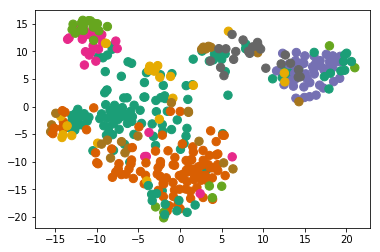

In [19]:
stat(clustre)

In [28]:
dataset = []
target = []
for i in range(10):
    dataset = dataset + clustre[i]
    for j in range(len(clustre[i])):
        target.append(i)

In [29]:
len(dataset)

404

In [32]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets

In [33]:
metrics.silhouette_score(dataset, target, metric='euclidean')

0.02925520598930657

In [34]:
import numpy as np
from sklearn.cluster import KMeans


In [38]:
kmeans_model = KMeans(n_clusters=10, random_state=1).fit(dataset)
labels = kmeans_model.labels_

In [39]:
metrics.silhouette_score(dataset, labels, metric='euclidean')


0.1282629418457457